# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11667
EM converged at iteration 58, llf=-11491, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-11680
EM converged at iteration 58, llf=-11502, convergence criterion=9.7404e-07 < tolerance=1e-06
EM start iterations, llf=-11731
EM converged at iteration 58, llf=-11551, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-11740
EM converged at iteration 58, llf=-11560, convergence criterion=9.748e-07 < tolerance=1e-06
EM start iterations, llf=-11802
EM converged at iteration 58, llf=-11621, convergence criterion=9.7864e-07 < tolerance=1e-06
EM start iterations, llf=-11810
EM converged at iteration 58, llf=-11629, convergence criterion=9.8002e-07 < tolerance=1e-06
EM start iterations, llf=-11863
EM converged at iteration 58, llf=-11682, convergence criterion=9.7111e-07 < tolerance=1e-06
EM start iterations, llf=-11863
EM converged at iteration 58, llf=-11682, convergence criterion=9.7111e-07 < tolerance=1e-06
E

EM start iterations, llf=-13242
EM converged at iteration 34, llf=-13077, convergence criterion=9.4858e-07 < tolerance=1e-06
EM start iterations, llf=-13293
EM converged at iteration 33, llf=-13128, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-13303
EM converged at iteration 33, llf=-13139, convergence criterion=9.994e-07 < tolerance=1e-06
EM start iterations, llf=-13357
EM converged at iteration 33, llf=-13190, convergence criterion=9.8898e-07 < tolerance=1e-06
EM start iterations, llf=-13357
EM converged at iteration 33, llf=-13190, convergence criterion=9.8898e-07 < tolerance=1e-06
EM start iterations, llf=-13368
EM converged at iteration 33, llf=-13200, convergence criterion=9.8901e-07 < tolerance=1e-06
EM start iterations, llf=-13416
EM converged at iteration 33, llf=-13248, convergence criterion=9.7536e-07 < tolerance=1e-06
EM start iterations, llf=-13423
EM converged at iteration 33, llf=-13254, convergence criterion=9.9127e-07 < tolerance=1e-06
E

EM start iterations, llf=-14940
EM converged at iteration 33, llf=-14760, convergence criterion=9.7344e-07 < tolerance=1e-06
EM start iterations, llf=-14940
EM converged at iteration 33, llf=-14760, convergence criterion=9.7344e-07 < tolerance=1e-06
EM start iterations, llf=-14949
EM converged at iteration 33, llf=-14770, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-15002
EM converged at iteration 33, llf=-14822, convergence criterion=9.663e-07 < tolerance=1e-06
EM start iterations, llf=-15013
EM converged at iteration 33, llf=-14833, convergence criterion=9.7069e-07 < tolerance=1e-06
EM start iterations, llf=-15061
EM converged at iteration 33, llf=-14881, convergence criterion=9.6904e-07 < tolerance=1e-06
EM start iterations, llf=-15069
EM converged at iteration 33, llf=-14889, convergence criterion=9.7132e-07 < tolerance=1e-06
EM start iterations, llf=-15116
EM converged at iteration 33, llf=-14936, convergence criterion=9.7326e-07 < tolerance=1e-06
E

EM start iterations, llf=-16645
EM converged at iteration 27, llf=-16453, convergence criterion=9.7094e-07 < tolerance=1e-06
EM start iterations, llf=-16651
EM converged at iteration 27, llf=-16459, convergence criterion=9.8921e-07 < tolerance=1e-06
EM start iterations, llf=-16703
EM converged at iteration 27, llf=-16510, convergence criterion=9.8405e-07 < tolerance=1e-06
EM start iterations, llf=-16710
EM converged at iteration 27, llf=-16518, convergence criterion=9.8531e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 27, llf=-16572, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 27, llf=-16572, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-16773
EM converged at iteration 27, llf=-16579, convergence criterion=9.7782e-07 < tolerance=1e-06
EM start iterations, llf=-16825
EM converged at iteration 27, llf=-16630, convergence criterion=9.7055e-07 < tolerance=1e-06


EM start iterations, llf=-18130
EM converged at iteration 29, llf=-17932, convergence criterion=9.7526e-07 < tolerance=1e-06
EM start iterations, llf=-18189
EM converged at iteration 29, llf=-17991, convergence criterion=9.6997e-07 < tolerance=1e-06
EM start iterations, llf=-18189
EM converged at iteration 29, llf=-17991, convergence criterion=9.6997e-07 < tolerance=1e-06
EM start iterations, llf=-18195
EM converged at iteration 29, llf=-17996, convergence criterion=9.688e-07 < tolerance=1e-06
EM start iterations, llf=-18249
EM converged at iteration 29, llf=-18050, convergence criterion=9.6781e-07 < tolerance=1e-06
EM start iterations, llf=-18256
EM converged at iteration 30, llf=-18058, convergence criterion=9.4009e-07 < tolerance=1e-06
EM start iterations, llf=-18311
EM converged at iteration 30, llf=-18111, convergence criterion=9.4266e-07 < tolerance=1e-06
EM start iterations, llf=-18318
EM converged at iteration 30, llf=-18118, convergence criterion=9.4074e-07 < tolerance=1e-06
E

EM converged at iteration 42, llf=-12044, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-12236
EM converged at iteration 44, llf=-12035, convergence criterion=9.6331e-07 < tolerance=1e-06
EM start iterations, llf=-12288
EM converged at iteration 41, llf=-12102, convergence criterion=9.7646e-07 < tolerance=1e-06
EM start iterations, llf=-12297
EM converged at iteration 45, llf=-12124, convergence criterion=9.6212e-07 < tolerance=1e-06
EM start iterations, llf=-12300
EM converged at iteration 45, llf=-12136, convergence criterion=9.7538e-07 < tolerance=1e-06
EM start iterations, llf=-12302
EM converged at iteration 45, llf=-12138, convergence criterion=9.7189e-07 < tolerance=1e-06
EM start iterations, llf=-12292
EM converged at iteration 46, llf=-12132, convergence criterion=9.5627e-07 < tolerance=1e-06
EM start iterations, llf=-12292
EM converged at iteration 46, llf=-12132, convergence criterion=9.5627e-07 < tolerance=1e-06
EM start iterations, llf=-12288


EM start iterations, llf=-13773
EM converged at iteration 45, llf=-13604, convergence criterion=9.6828e-07 < tolerance=1e-06
EM start iterations, llf=-13811
EM converged at iteration 45, llf=-13644, convergence criterion=9.6274e-07 < tolerance=1e-06
EM start iterations, llf=-13813
EM converged at iteration 45, llf=-13644, convergence criterion=9.5664e-07 < tolerance=1e-06
EM start iterations, llf=-13853
EM converged at iteration 44, llf=-13682, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-13853
EM converged at iteration 44, llf=-13682, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-13863
EM converged at iteration 44, llf=-13692, convergence criterion=9.735e-07 < tolerance=1e-06
EM start iterations, llf=-13915
EM converged at iteration 44, llf=-13744, convergence criterion=9.6083e-07 < tolerance=1e-06
EM start iterations, llf=-13923
EM converged at iteration 41, llf=-13753, convergence criterion=9.8575e-07 < tolerance=1e-06
E

EM start iterations, llf=-15498
EM converged at iteration 41, llf=-15311, convergence criterion=9.8707e-07 < tolerance=1e-06
EM start iterations, llf=-15498
EM converged at iteration 41, llf=-15311, convergence criterion=9.8707e-07 < tolerance=1e-06
EM start iterations, llf=-15507
EM converged at iteration 42, llf=-15321, convergence criterion=9.6232e-07 < tolerance=1e-06
EM start iterations, llf=-15559
EM converged at iteration 41, llf=-15373, convergence criterion=9.8903e-07 < tolerance=1e-06
EM start iterations, llf=-15563
EM converged at iteration 39, llf=-15376, convergence criterion=9.9777e-07 < tolerance=1e-06
EM start iterations, llf=-15623
EM converged at iteration 40, llf=-15436, convergence criterion=9.8047e-07 < tolerance=1e-06
EM start iterations, llf=-15628
EM converged at iteration 40, llf=-15442, convergence criterion=9.8283e-07 < tolerance=1e-06
EM start iterations, llf=-15671
EM converged at iteration 40, llf=-15485, convergence criterion=9.8811e-07 < tolerance=1e-06


EM start iterations, llf=-17186
EM converged at iteration 40, llf=-16988, convergence criterion=9.9261e-07 < tolerance=1e-06
EM start iterations, llf=-17193
EM converged at iteration 40, llf=-16995, convergence criterion=9.9221e-07 < tolerance=1e-06
EM start iterations, llf=-17242
EM converged at iteration 41, llf=-17044, convergence criterion=9.7069e-07 < tolerance=1e-06
EM start iterations, llf=-17251
EM converged at iteration 41, llf=-17053, convergence criterion=9.7289e-07 < tolerance=1e-06
EM start iterations, llf=-17297
EM converged at iteration 41, llf=-17098, convergence criterion=9.6742e-07 < tolerance=1e-06
EM start iterations, llf=-17297
EM converged at iteration 41, llf=-17098, convergence criterion=9.6742e-07 < tolerance=1e-06
EM start iterations, llf=-17316
EM converged at iteration 41, llf=-17118, convergence criterion=9.646e-07 < tolerance=1e-06
EM start iterations, llf=-17368
EM converged at iteration 41, llf=-17169, convergence criterion=9.6773e-07 < tolerance=1e-06
E

EM start iterations, llf=-18677
EM converged at iteration 39, llf=-18473, convergence criterion=9.7153e-07 < tolerance=1e-06
EM start iterations, llf=-18726
EM converged at iteration 39, llf=-18521, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-18726
EM converged at iteration 39, llf=-18521, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-18733
EM converged at iteration 39, llf=-18529, convergence criterion=9.682e-07 < tolerance=1e-06
EM start iterations, llf=-18789
EM converged at iteration 38, llf=-18584, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-18799
EM converged at iteration 39, llf=-18594, convergence criterion=9.6349e-07 < tolerance=1e-06
EM start iterations, llf=-18851
EM converged at iteration 39, llf=-18646, convergence criterion=9.6113e-07 < tolerance=1e-06
EM start iterations, llf=-18860
EM converged at iteration 39, llf=-18655, convergence criterion=9.6298e-07 < tolerance=1e-06
E

EM converged at iteration 59, llf=-12425, convergence criterion=9.7321e-07 < tolerance=1e-06
EM start iterations, llf=-12582
EM converged at iteration 59, llf=-12425, convergence criterion=9.7321e-07 < tolerance=1e-06
EM start iterations, llf=-12591
EM converged at iteration 56, llf=-12434, convergence criterion=9.9305e-07 < tolerance=1e-06
EM start iterations, llf=-12639
EM converged at iteration 59, llf=-12482, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-12649
EM converged at iteration 56, llf=-12492, convergence criterion=9.7271e-07 < tolerance=1e-06
EM start iterations, llf=-12702
EM converged at iteration 59, llf=-12546, convergence criterion=9.8077e-07 < tolerance=1e-06
EM start iterations, llf=-12713
EM converged at iteration 59, llf=-12557, convergence criterion=9.8397e-07 < tolerance=1e-06
EM start iterations, llf=-12764
EM converged at iteration 60, llf=-12606, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-12764
E

EM start iterations, llf=-14195
EM converged at iteration 71, llf=-14027, convergence criterion=9.8622e-07 < tolerance=1e-06
EM start iterations, llf=-14205
EM converged at iteration 73, llf=-14035, convergence criterion=9.9147e-07 < tolerance=1e-06
EM start iterations, llf=-14276
EM converged at iteration 82, llf=-14104, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-14282
EM converged at iteration 81, llf=-14111, convergence criterion=9.7861e-07 < tolerance=1e-06
EM start iterations, llf=-14337
EM converged at iteration 84, llf=-14165, convergence criterion=9.8988e-07 < tolerance=1e-06
EM start iterations, llf=-14347
EM converged at iteration 81, llf=-14175, convergence criterion=9.7576e-07 < tolerance=1e-06
EM start iterations, llf=-14396
EM converged at iteration 82, llf=-14223, convergence criterion=9.7806e-07 < tolerance=1e-06
EM start iterations, llf=-14396
EM converged at iteration 82, llf=-14223, convergence criterion=9.7806e-07 < tolerance=1e-06


EM start iterations, llf=-15918
EM converged at iteration 83, llf=-15734, convergence criterion=9.7924e-07 < tolerance=1e-06
EM start iterations, llf=-15974
EM converged at iteration 80, llf=-15790, convergence criterion=9.8679e-07 < tolerance=1e-06
EM start iterations, llf=-15979
EM converged at iteration 80, llf=-15796, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-16035
EM converged at iteration 79, llf=-15851, convergence criterion=9.927e-07 < tolerance=1e-06
EM start iterations, llf=-16035
EM converged at iteration 79, llf=-15851, convergence criterion=9.927e-07 < tolerance=1e-06
EM start iterations, llf=-16045
EM converged at iteration 79, llf=-15861, convergence criterion=9.9378e-07 < tolerance=1e-06
EM start iterations, llf=-16096
EM converged at iteration 79, llf=-15912, convergence criterion=9.8132e-07 < tolerance=1e-06
EM start iterations, llf=-16106
EM converged at iteration 80, llf=-15922, convergence criterion=9.7954e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17655
EM converged at iteration 74, llf=-17462, convergence criterion=9.953e-07 < tolerance=1e-06
EM start iterations, llf=-17655
EM converged at iteration 74, llf=-17462, convergence criterion=9.953e-07 < tolerance=1e-06
EM start iterations, llf=-17662
EM converged at iteration 74, llf=-17469, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-17711
EM converged at iteration 75, llf=-17517, convergence criterion=9.7777e-07 < tolerance=1e-06
EM start iterations, llf=-17717
EM converged at iteration 75, llf=-17523, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-17768
EM converged at iteration 76, llf=-17574, convergence criterion=9.9531e-07 < tolerance=1e-06
EM start iterations, llf=-17776
EM converged at iteration 76, llf=-17581, convergence criterion=9.8545e-07 < tolerance=1e-06
EM start iterations, llf=-17830
EM converged at iteration 73, llf=-17635, convergence criterion=9.9876e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18866
EM converged at iteration 68, llf=-18670, convergence criterion=9.8357e-07 < tolerance=1e-06
EM start iterations, llf=-18879
EM converged at iteration 68, llf=-18683, convergence criterion=9.8533e-07 < tolerance=1e-06
EM start iterations, llf=-18934
EM converged at iteration 68, llf=-18737, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-18938
EM converged at iteration 68, llf=-18742, convergence criterion=9.8088e-07 < tolerance=1e-06
EM start iterations, llf=-18993
EM converged at iteration 68, llf=-18796, convergence criterion=9.8421e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 2:15:27.297905.
EM start iterations, llf=-11167
EM converged at iteration 59, llf=-11006, convergence criterion=9.8196e-07 < tolerance=1e-06
EM start iterations, llf=-11179
EM converged at iteration 59, llf=-11018, convergence criterion=9.712e-07 < tolerance=1e-06
EM start iterations, llf=-11229
EM converged at itera

EM start iterations, llf=-12469
EM converged at iteration 42, llf=-12303, convergence criterion=9.6423e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 41, llf=-12340, convergence criterion=9.5326e-07 < tolerance=1e-06
EM start iterations, llf=-12552
EM converged at iteration 41, llf=-12387, convergence criterion=9.6037e-07 < tolerance=1e-06
EM start iterations, llf=-12552
EM converged at iteration 41, llf=-12387, convergence criterion=9.6037e-07 < tolerance=1e-06
EM start iterations, llf=-12562
EM converged at iteration 41, llf=-12397, convergence criterion=9.5408e-07 < tolerance=1e-06
EM start iterations, llf=-12596
EM converged at iteration 39, llf=-12433, convergence criterion=9.7595e-07 < tolerance=1e-06
EM start iterations, llf=-12595
EM converged at iteration 37, llf=-12432, convergence criterion=9.934e-07 < tolerance=1e-06
EM start iterations, llf=-12644
EM converged at iteration 36, llf=-12482, convergence criterion=9.593e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14060
EM converged at iteration 37, llf=-13883, convergence criterion=9.7566e-07 < tolerance=1e-06
EM start iterations, llf=-14067
EM converged at iteration 37, llf=-13889, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-14111
EM converged at iteration 37, llf=-13935, convergence criterion=9.7932e-07 < tolerance=1e-06
EM start iterations, llf=-14119
EM converged at iteration 37, llf=-13943, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-14167
EM converged at iteration 37, llf=-13991, convergence criterion=9.7143e-07 < tolerance=1e-06
EM start iterations, llf=-14177
EM converged at iteration 37, llf=-14000, convergence criterion=9.7644e-07 < tolerance=1e-06
EM start iterations, llf=-14229
EM converged at iteration 37, llf=-14054, convergence criterion=9.474e-07 < tolerance=1e-06
EM start iterations, llf=-14229
EM converged at iteration 37, llf=-14054, convergence criterion=9.474e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15687
EM converged at iteration 30, llf=-15501, convergence criterion=9.3924e-07 < tolerance=1e-06
EM start iterations, llf=-15741
EM converged at iteration 29, llf=-15553, convergence criterion=9.9653e-07 < tolerance=1e-06
EM start iterations, llf=-15748
EM converged at iteration 29, llf=-15560, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-15790
EM converged at iteration 29, llf=-15603, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-15790
EM converged at iteration 29, llf=-15603, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-15805
EM converged at iteration 29, llf=-15618, convergence criterion=9.9896e-07 < tolerance=1e-06
EM start iterations, llf=-15861
EM converged at iteration 29, llf=-15674, convergence criterion=9.9694e-07 < tolerance=1e-06
EM start iterations, llf=-15864
EM converged at iteration 29, llf=-15678, convergence criterion=9.8759e-07 < tolerance=1e-06


EM start iterations, llf=-17163
EM converged at iteration 31, llf=-16975, convergence criterion=9.4615e-07 < tolerance=1e-06
EM start iterations, llf=-17163
EM converged at iteration 31, llf=-16975, convergence criterion=9.4615e-07 < tolerance=1e-06
EM start iterations, llf=-17166
EM converged at iteration 30, llf=-16978, convergence criterion=9.9901e-07 < tolerance=1e-06
EM start iterations, llf=-17211
EM converged at iteration 30, llf=-17023, convergence criterion=9.7213e-07 < tolerance=1e-06
EM start iterations, llf=-17227
EM converged at iteration 30, llf=-17039, convergence criterion=9.893e-07 < tolerance=1e-06
EM start iterations, llf=-17283
EM converged at iteration 30, llf=-17093, convergence criterion=9.7999e-07 < tolerance=1e-06
EM start iterations, llf=-17287
EM converged at iteration 30, llf=-17097, convergence criterion=9.7729e-07 < tolerance=1e-06
EM start iterations, llf=-17344
EM converged at iteration 30, llf=-17154, convergence criterion=9.5895e-07 < tolerance=1e-06
E

EM converged at iteration 58, llf=-11360, convergence criterion=9.6816e-07 < tolerance=1e-06
EM start iterations, llf=-11570
EM converged at iteration 60, llf=-11412, convergence criterion=9.8421e-07 < tolerance=1e-06
EM start iterations, llf=-11589
EM converged at iteration 48, llf=-11428, convergence criterion=9.9902e-07 < tolerance=1e-06
EM start iterations, llf=-11631
EM converged at iteration 46, llf=-11469, convergence criterion=9.6379e-07 < tolerance=1e-06
EM start iterations, llf=-11635
EM converged at iteration 46, llf=-11473, convergence criterion=9.8069e-07 < tolerance=1e-06
EM start iterations, llf=-11696
EM converged at iteration 41, llf=-11541, convergence criterion=9.7506e-07 < tolerance=1e-06
EM start iterations, llf=-11696
EM converged at iteration 41, llf=-11541, convergence criterion=9.7506e-07 < tolerance=1e-06
EM start iterations, llf=-11710
EM converged at iteration 46, llf=-11551, convergence criterion=9.7657e-07 < tolerance=1e-06
EM start iterations, llf=-11752


EM start iterations, llf=-12978
EM converged at iteration 56, llf=-12806, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-12986
EM converged at iteration 57, llf=-12812, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-13030
EM converged at iteration 58, llf=-12854, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-13030
EM converged at iteration 58, llf=-12854, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-13038
EM converged at iteration 58, llf=-12864, convergence criterion=9.8962e-07 < tolerance=1e-06
EM start iterations, llf=-13075
EM converged at iteration 58, llf=-12902, convergence criterion=9.8147e-07 < tolerance=1e-06
EM start iterations, llf=-13081
EM converged at iteration 60, llf=-12910, convergence criterion=9.8552e-07 < tolerance=1e-06
EM start iterations, llf=-13114
EM converged at iteration 59, llf=-12944, convergence criterion=9.9094e-07 < tolerance=1e-06


EM start iterations, llf=-14579
EM converged at iteration 55, llf=-14398, convergence criterion=9.7365e-07 < tolerance=1e-06
EM start iterations, llf=-14590
EM converged at iteration 54, llf=-14409, convergence criterion=9.9166e-07 < tolerance=1e-06
EM start iterations, llf=-14642
EM converged at iteration 53, llf=-14461, convergence criterion=9.8102e-07 < tolerance=1e-06
EM start iterations, llf=-14651
EM converged at iteration 53, llf=-14471, convergence criterion=9.7387e-07 < tolerance=1e-06
EM start iterations, llf=-14705
EM converged at iteration 51, llf=-14524, convergence criterion=9.7446e-07 < tolerance=1e-06
EM start iterations, llf=-14710
EM converged at iteration 51, llf=-14529, convergence criterion=9.99e-07 < tolerance=1e-06
EM start iterations, llf=-14756
EM converged at iteration 54, llf=-14574, convergence criterion=9.8059e-07 < tolerance=1e-06
EM start iterations, llf=-14756
EM converged at iteration 54, llf=-14574, convergence criterion=9.8059e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16205
EM converged at iteration 51, llf=-16013, convergence criterion=9.7481e-07 < tolerance=1e-06
EM start iterations, llf=-16256
EM converged at iteration 51, llf=-16064, convergence criterion=9.767e-07 < tolerance=1e-06
EM start iterations, llf=-16264
EM converged at iteration 50, llf=-16071, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-16315
EM converged at iteration 49, llf=-16124, convergence criterion=9.8745e-07 < tolerance=1e-06
EM start iterations, llf=-16315
EM converged at iteration 49, llf=-16124, convergence criterion=9.8745e-07 < tolerance=1e-06
EM start iterations, llf=-16323
EM converged at iteration 48, llf=-16131, convergence criterion=9.9005e-07 < tolerance=1e-06
EM start iterations, llf=-16366
EM converged at iteration 48, llf=-16175, convergence criterion=9.8777e-07 < tolerance=1e-06
EM start iterations, llf=-16373
EM converged at iteration 48, llf=-16181, convergence criterion=9.9602e-07 < tolerance=1e-06
E

EM start iterations, llf=-17690
EM converged at iteration 42, llf=-17497, convergence criterion=9.7616e-07 < tolerance=1e-06
EM start iterations, llf=-17690
EM converged at iteration 42, llf=-17497, convergence criterion=9.7616e-07 < tolerance=1e-06
EM start iterations, llf=-17700
EM converged at iteration 42, llf=-17506, convergence criterion=9.9611e-07 < tolerance=1e-06
EM start iterations, llf=-17746
EM converged at iteration 42, llf=-17553, convergence criterion=9.915e-07 < tolerance=1e-06
EM start iterations, llf=-17753
EM converged at iteration 42, llf=-17559, convergence criterion=9.8388e-07 < tolerance=1e-06
EM start iterations, llf=-17803
EM converged at iteration 42, llf=-17608, convergence criterion=9.9293e-07 < tolerance=1e-06
EM start iterations, llf=-17810
EM converged at iteration 42, llf=-17615, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-17855
EM converged at iteration 42, llf=-17660, convergence criterion=9.8705e-07 < tolerance=1e-06
E

EM start iterations, llf=-11795
EM converged at iteration 83, llf=-11624, convergence criterion=9.9048e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM converged at iteration 79, llf=-11676, convergence criterion=9.8966e-07 < tolerance=1e-06
EM start iterations, llf=-11849
EM converged at iteration 76, llf=-11677, convergence criterion=9.9089e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM converged at iteration 78, llf=-11733, convergence criterion=9.7526e-07 < tolerance=1e-06
EM start iterations, llf=-11917
EM converged at iteration 76, llf=-11746, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 72, llf=-11800, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 72, llf=-11800, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM converged at iteration 74, llf=-11815, convergence criterion=9.7695e-07 < tolerance=1e-06


EM start iterations, llf=-13465
EM converged at iteration 76, llf=-13283, convergence criterion=9.8752e-07 < tolerance=1e-06
EM start iterations, llf=-13485
EM converged at iteration 77, llf=-13303, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 78, llf=-13343, convergence criterion=9.9018e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 78, llf=-13343, convergence criterion=9.9018e-07 < tolerance=1e-06
EM start iterations, llf=-13527
EM converged at iteration 77, llf=-13345, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-13584
EM converged at iteration 73, llf=-13403, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-13589
EM converged at iteration 69, llf=-13409, convergence criterion=9.8481e-07 < tolerance=1e-06
EM start iterations, llf=-13644
EM converged at iteration 70, llf=-13463, convergence criterion=9.8002e-07 < tolerance=1e-06


EM start iterations, llf=-15109
EM converged at iteration 69, llf=-14921, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-15119
EM converged at iteration 68, llf=-14930, convergence criterion=9.9515e-07 < tolerance=1e-06
EM start iterations, llf=-15164
EM converged at iteration 68, llf=-14975, convergence criterion=9.8886e-07 < tolerance=1e-06
EM start iterations, llf=-15171
EM converged at iteration 69, llf=-14982, convergence criterion=9.8305e-07 < tolerance=1e-06
EM start iterations, llf=-15225
EM converged at iteration 67, llf=-15034, convergence criterion=9.8962e-07 < tolerance=1e-06
EM start iterations, llf=-15227
EM converged at iteration 66, llf=-15037, convergence criterion=9.9042e-07 < tolerance=1e-06
EM start iterations, llf=-15280
EM converged at iteration 66, llf=-15090, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-15280
EM converged at iteration 66, llf=-15090, convergence criterion=9.827e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16719
EM converged at iteration 57, llf=-16527, convergence criterion=9.9105e-07 < tolerance=1e-06
EM start iterations, llf=-16774
EM converged at iteration 59, llf=-16581, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-16781
EM converged at iteration 59, llf=-16588, convergence criterion=9.8804e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 60, llf=-16636, convergence criterion=9.9307e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 60, llf=-16636, convergence criterion=9.9307e-07 < tolerance=1e-06
EM start iterations, llf=-16836
EM converged at iteration 60, llf=-16643, convergence criterion=9.9927e-07 < tolerance=1e-06
EM start iterations, llf=-16883
EM converged at iteration 56, llf=-16691, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-16889
EM converged at iteration 56, llf=-16698, convergence criterion=9.8456e-07 < tolerance=1e-06


EM start iterations, llf=-18202
EM converged at iteration 60, llf=-18003, convergence criterion=9.9834e-07 < tolerance=1e-06
EM start iterations, llf=-18202
EM converged at iteration 60, llf=-18003, convergence criterion=9.9834e-07 < tolerance=1e-06
EM start iterations, llf=-17932
EM converged at iteration 54, llf=-17739, convergence criterion=9.8714e-07 < tolerance=1e-06
EM start iterations, llf=-17982
EM converged at iteration 50, llf=-17791, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-17994
EM converged at iteration 50, llf=-17803, convergence criterion=9.7977e-07 < tolerance=1e-06
EM start iterations, llf=-18048
EM converged at iteration 50, llf=-17856, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-18052
EM converged at iteration 50, llf=-17861, convergence criterion=9.9105e-07 < tolerance=1e-06
EM start iterations, llf=-18105
EM converged at iteration 50, llf=-17914, convergence criterion=9.8262e-07 < tolerance=1e-06
M

EM start iterations, llf=-11986
EM converged at iteration 35, llf=-11842, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-11998
EM converged at iteration 35, llf=-11853, convergence criterion=9.6856e-07 < tolerance=1e-06
EM start iterations, llf=-12048
EM converged at iteration 35, llf=-11903, convergence criterion=9.5983e-07 < tolerance=1e-06
EM start iterations, llf=-12062
EM converged at iteration 38, llf=-11917, convergence criterion=9.5317e-07 < tolerance=1e-06
EM start iterations, llf=-12109
EM converged at iteration 37, llf=-11964, convergence criterion=9.945e-07 < tolerance=1e-06
EM start iterations, llf=-12167
EM converged at iteration 38, llf=-12016, convergence criterion=9.4892e-07 < tolerance=1e-06
EM start iterations, llf=-12201
EM converged at iteration 38, llf=-12053, convergence criterion=9.9866e-07 < tolerance=1e-06
EM start iterations, llf=-12201
EM converged at iteration 38, llf=-12053, convergence criterion=9.9866e-07 < tolerance=1e-06
E

EM start iterations, llf=-13555
EM converged at iteration 39, llf=-13396, convergence criterion=9.7553e-07 < tolerance=1e-06
EM start iterations, llf=-13616
EM converged at iteration 39, llf=-13451, convergence criterion=9.9098e-07 < tolerance=1e-06
EM start iterations, llf=-13618
EM converged at iteration 40, llf=-13456, convergence criterion=9.6082e-07 < tolerance=1e-06
EM start iterations, llf=-13677
EM converged at iteration 39, llf=-13512, convergence criterion=9.7874e-07 < tolerance=1e-06
EM start iterations, llf=-13677
EM converged at iteration 39, llf=-13512, convergence criterion=9.7874e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM converged at iteration 39, llf=-13516, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-13724
EM converged at iteration 39, llf=-13563, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-13734
EM converged at iteration 39, llf=-13571, convergence criterion=9.935e-07 < tolerance=1e-06
E

EM start iterations, llf=-15214
EM converged at iteration 34, llf=-15053, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-15214
EM converged at iteration 34, llf=-15053, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-15222
EM converged at iteration 34, llf=-15060, convergence criterion=9.5495e-07 < tolerance=1e-06
EM start iterations, llf=-15274
EM converged at iteration 34, llf=-15110, convergence criterion=9.4313e-07 < tolerance=1e-06
EM start iterations, llf=-15277
EM converged at iteration 34, llf=-15113, convergence criterion=9.565e-07 < tolerance=1e-06
EM start iterations, llf=-15328
EM converged at iteration 34, llf=-15164, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-15336
EM converged at iteration 34, llf=-15173, convergence criterion=9.5963e-07 < tolerance=1e-06
EM start iterations, llf=-15380
EM converged at iteration 34, llf=-15216, convergence criterion=9.6705e-07 < tolerance=1e-06
E

EM start iterations, llf=-16818
EM converged at iteration 35, llf=-16651, convergence criterion=9.8966e-07 < tolerance=1e-06
EM start iterations, llf=-16828
EM converged at iteration 36, llf=-16661, convergence criterion=9.6044e-07 < tolerance=1e-06
EM start iterations, llf=-16871
EM converged at iteration 35, llf=-16707, convergence criterion=9.4593e-07 < tolerance=1e-06
EM start iterations, llf=-16878
EM converged at iteration 35, llf=-16713, convergence criterion=9.6051e-07 < tolerance=1e-06
EM start iterations, llf=-16716
EM converged at iteration 35, llf=-16559, convergence criterion=9.8979e-07 < tolerance=1e-06
EM start iterations, llf=-16716
EM converged at iteration 35, llf=-16559, convergence criterion=9.8979e-07 < tolerance=1e-06
EM start iterations, llf=-16725
EM converged at iteration 35, llf=-16566, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-16775
EM converged at iteration 35, llf=-16612, convergence criterion=9.7901e-07 < tolerance=1e-06


EM start iterations, llf=-11262
EM converged at iteration 55, llf=-11094, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-11261
EM converged at iteration 58, llf=-11097, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-11292
EM converged at iteration 50, llf=-11133, convergence criterion=9.6537e-07 < tolerance=1e-06
EM start iterations, llf=-11292
EM converged at iteration 50, llf=-11133, convergence criterion=9.6537e-07 < tolerance=1e-06
EM start iterations, llf=-11307
EM converged at iteration 52, llf=-11147, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-11343
EM converged at iteration 50, llf=-11188, convergence criterion=9.8676e-07 < tolerance=1e-06
EM start iterations, llf=-11348
EM converged at iteration 44, llf=-11196, convergence criterion=9.6229e-07 < tolerance=1e-06
EM start iterations, llf=-11379
EM converged at iteration 42, llf=-11229, convergence criterion=9.9987e-07 < tolerance=1e-06


EM converged at iteration 39, llf=-12327, convergence criterion=9.8424e-07 < tolerance=1e-06
EM start iterations, llf=-12534
EM converged at iteration 38, llf=-12373, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-12534
EM converged at iteration 38, llf=-12373, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-12547
EM converged at iteration 38, llf=-12384, convergence criterion=9.7633e-07 < tolerance=1e-06
EM start iterations, llf=-12589
EM converged at iteration 36, llf=-12426, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-12601
EM converged at iteration 38, llf=-12437, convergence criterion=9.9788e-07 < tolerance=1e-06
EM start iterations, llf=-12644
EM converged at iteration 38, llf=-12481, convergence criterion=9.9227e-07 < tolerance=1e-06
EM start iterations, llf=-12654
EM converged at iteration 39, llf=-12491, convergence criterion=9.6421e-07 < tolerance=1e-06
EM start iterations, llf=-12690


EM start iterations, llf=-14018
EM converged at iteration 48, llf=-13856, convergence criterion=9.9748e-07 < tolerance=1e-06
EM start iterations, llf=-14052
EM converged at iteration 50, llf=-13892, convergence criterion=9.8344e-07 < tolerance=1e-06
EM start iterations, llf=-14062
EM converged at iteration 50, llf=-13902, convergence criterion=9.8305e-07 < tolerance=1e-06
EM start iterations, llf=-14120
EM converged at iteration 52, llf=-13958, convergence criterion=9.9405e-07 < tolerance=1e-06
EM start iterations, llf=-14133
EM converged at iteration 51, llf=-13972, convergence criterion=9.9823e-07 < tolerance=1e-06
EM start iterations, llf=-14183
EM converged at iteration 51, llf=-14023, convergence criterion=9.7118e-07 < tolerance=1e-06
EM start iterations, llf=-14183
EM converged at iteration 51, llf=-14023, convergence criterion=9.7118e-07 < tolerance=1e-06
EM start iterations, llf=-14199
EM converged at iteration 49, llf=-14038, convergence criterion=9.8312e-07 < tolerance=1e-06


EM start iterations, llf=-15676
EM converged at iteration 44, llf=-15508, convergence criterion=9.88e-07 < tolerance=1e-06
EM start iterations, llf=-15685
EM converged at iteration 44, llf=-15518, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-15732
EM converged at iteration 44, llf=-15564, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-15732
EM converged at iteration 44, llf=-15564, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-15742
EM converged at iteration 43, llf=-15573, convergence criterion=9.9862e-07 < tolerance=1e-06
EM start iterations, llf=-15790
EM converged at iteration 44, llf=-15620, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-15795
EM converged at iteration 45, llf=-15625, convergence criterion=9.8648e-07 < tolerance=1e-06
EM start iterations, llf=-15845
EM converged at iteration 43, llf=-15675, convergence criterion=9.9874e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17069
EM converged at iteration 49, llf=-16907, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-17078
EM converged at iteration 48, llf=-16916, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-17131
EM converged at iteration 48, llf=-16969, convergence criterion=9.7247e-07 < tolerance=1e-06
EM start iterations, llf=-17137
EM converged at iteration 47, llf=-16975, convergence criterion=9.9138e-07 < tolerance=1e-06
EM start iterations, llf=-17179
EM converged at iteration 46, llf=-17019, convergence criterion=9.9955e-07 < tolerance=1e-06
EM start iterations, llf=-17193
EM converged at iteration 47, llf=-17033, convergence criterion=9.7317e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM converged at iteration 47, llf=-17077, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM converged at iteration 47, llf=-17077, convergence criterion=9.8749e-07 < tolerance=1e-06


EM converged at iteration 67, llf=-11316, convergence criterion=9.9833e-07 < tolerance=1e-06
EM start iterations, llf=-11453
EM converged at iteration 67, llf=-11306, convergence criterion=9.7984e-07 < tolerance=1e-06
EM start iterations, llf=-11481
EM converged at iteration 66, llf=-11332, convergence criterion=9.961e-07 < tolerance=1e-06
EM start iterations, llf=-11479
EM converged at iteration 69, llf=-11329, convergence criterion=9.694e-07 < tolerance=1e-06
EM start iterations, llf=-11427
EM iteration 100, llf=-10940, convergence criterion=1.9727e-06
EM converged at iteration 144, llf=-10940, convergence criterion=9.9034e-07 < tolerance=1e-06
EM start iterations, llf=-11427
EM iteration 100, llf=-10940, convergence criterion=1.9727e-06
EM converged at iteration 144, llf=-10940, convergence criterion=9.9034e-07 < tolerance=1e-06
EM start iterations, llf=-11441
EM iteration 100, llf=-10968, convergence criterion=1.7486e-06
EM converged at iteration 134, llf=-10967, convergence criter

EM start iterations, llf=-12917
EM converged at iteration 72, llf=-12746, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-12925
EM converged at iteration 73, llf=-12755, convergence criterion=9.7273e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 73, llf=-12805, convergence criterion=9.7245e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 73, llf=-12805, convergence criterion=9.7245e-07 < tolerance=1e-06
EM start iterations, llf=-12990
EM converged at iteration 73, llf=-12816, convergence criterion=9.803e-07 < tolerance=1e-06
EM start iterations, llf=-13032
EM converged at iteration 74, llf=-12857, convergence criterion=9.7831e-07 < tolerance=1e-06
EM start iterations, llf=-13044
EM converged at iteration 74, llf=-12869, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-13061
EM converged at iteration 80, llf=-12896, convergence criterion=9.8542e-07 < tolerance=1e-06
E

EM start iterations, llf=-14499
EM converged at iteration 83, llf=-14333, convergence criterion=9.9159e-07 < tolerance=1e-06
EM start iterations, llf=-13978
EM converged at iteration 89, llf=-13821, convergence criterion=9.9887e-07 < tolerance=1e-06
EM start iterations, llf=-14166
EM converged at iteration 87, llf=-14007, convergence criterion=9.9682e-07 < tolerance=1e-06
EM start iterations, llf=-14173
EM converged at iteration 88, llf=-14015, convergence criterion=9.8567e-07 < tolerance=1e-06
EM start iterations, llf=-14623
EM converged at iteration 82, llf=-14456, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-14628
EM converged at iteration 82, llf=-14461, convergence criterion=9.8268e-07 < tolerance=1e-06
EM start iterations, llf=-14674
EM converged at iteration 82, llf=-14506, convergence criterion=9.9959e-07 < tolerance=1e-06
EM start iterations, llf=-14674
EM converged at iteration 82, llf=-14506, convergence criterion=9.9959e-07 < tolerance=1e-06


EM start iterations, llf=-16127
EM converged at iteration 79, llf=-15949, convergence criterion=9.8695e-07 < tolerance=1e-06
EM start iterations, llf=-16168
EM converged at iteration 77, llf=-15992, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-16183
EM converged at iteration 77, llf=-16007, convergence criterion=9.9697e-07 < tolerance=1e-06
EM start iterations, llf=-16225
EM converged at iteration 80, llf=-16051, convergence criterion=9.7846e-07 < tolerance=1e-06
EM start iterations, llf=-16225
EM converged at iteration 80, llf=-16051, convergence criterion=9.7846e-07 < tolerance=1e-06
EM start iterations, llf=-16235
EM converged at iteration 80, llf=-16060, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-16280
EM converged at iteration 81, llf=-16104, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-16287
EM converged at iteration 82, llf=-16112, convergence criterion=9.9334e-07 < tolerance=1e-06


EM start iterations, llf=-17564
EM converged at iteration 78, llf=-17390, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-17564
EM converged at iteration 78, llf=-17390, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-17569
EM converged at iteration 78, llf=-17395, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-17623
EM converged at iteration 77, llf=-17447, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-17633
EM converged at iteration 77, llf=-17456, convergence criterion=9.8314e-07 < tolerance=1e-06
EM start iterations, llf=-17686
EM converged at iteration 76, llf=-17509, convergence criterion=9.9291e-07 < tolerance=1e-06
EM start iterations, llf=-17693
EM converged at iteration 76, llf=-17515, convergence criterion=9.9602e-07 < tolerance=1e-06
EM start iterations, llf=-17735
EM converged at iteration 77, llf=-17556, convergence criterion=9.81e-07 < tolerance=1e-06
EM

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


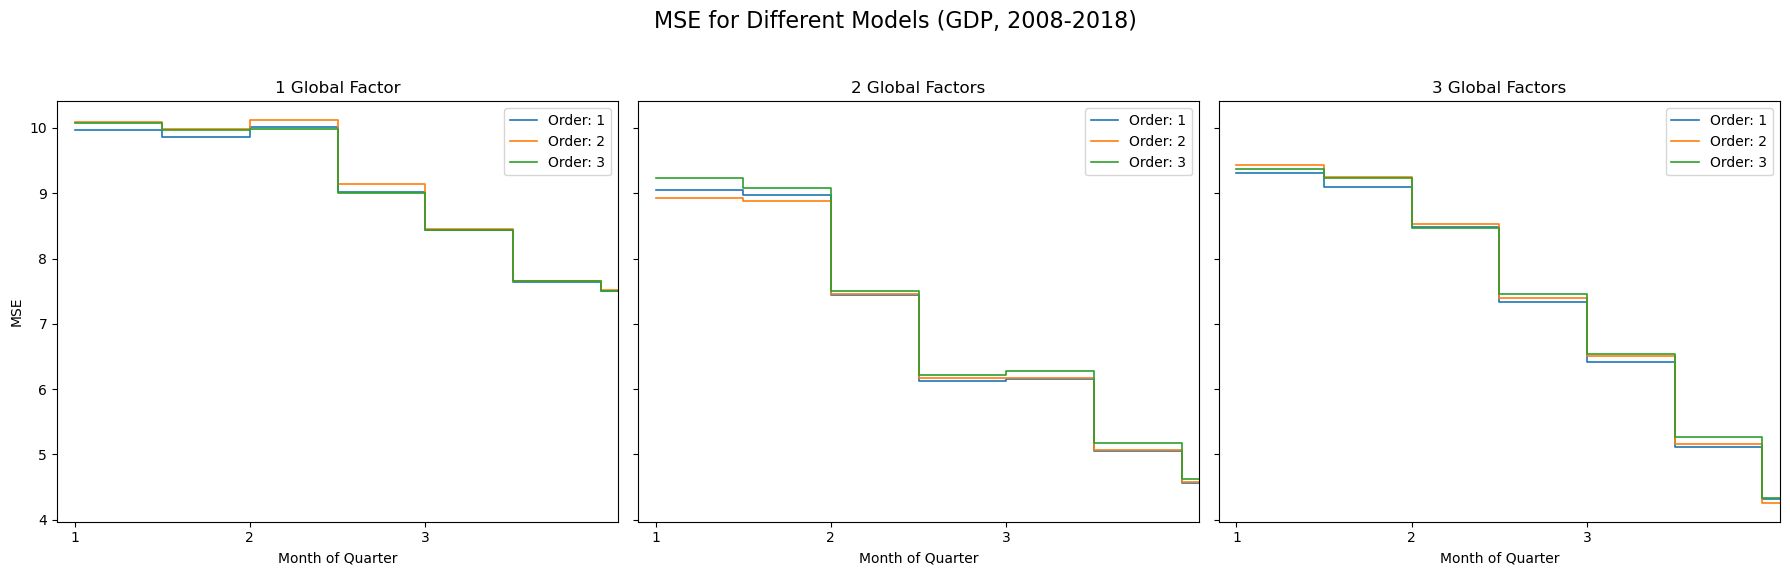

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


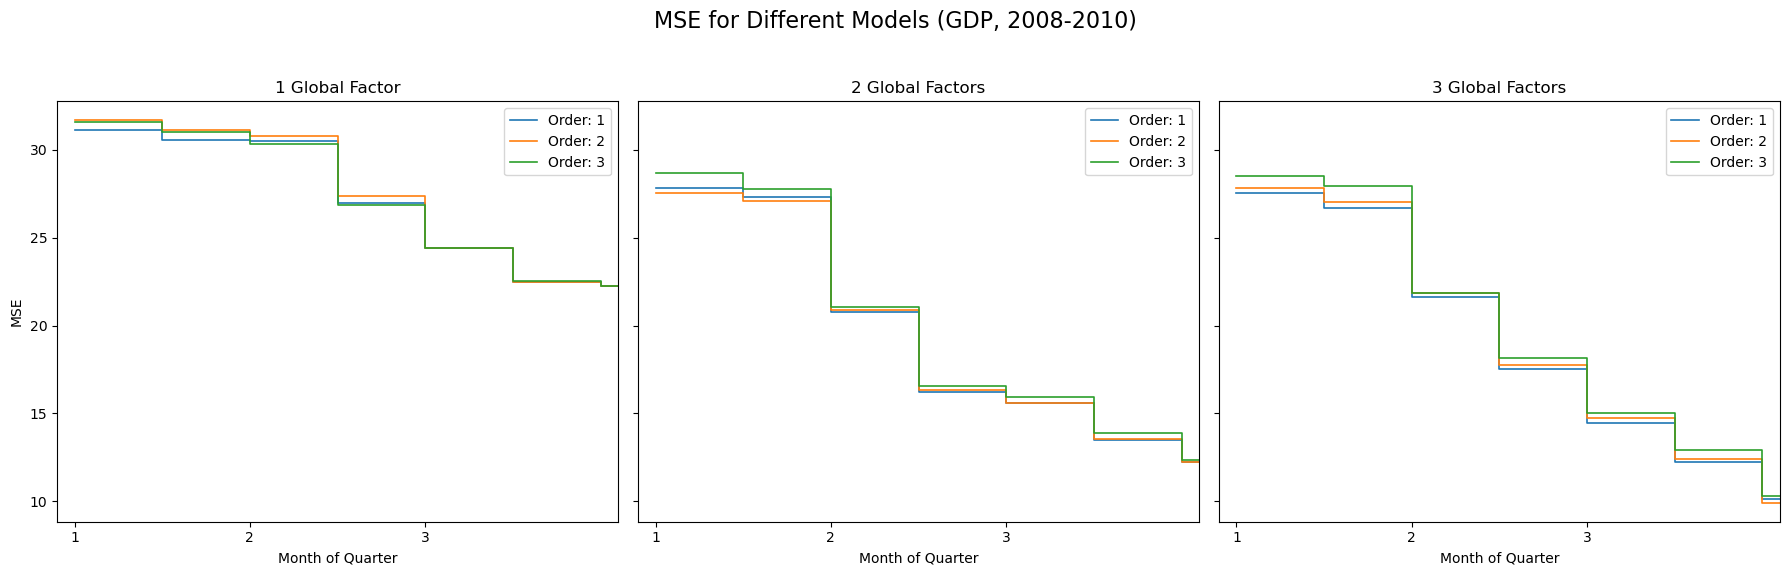

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


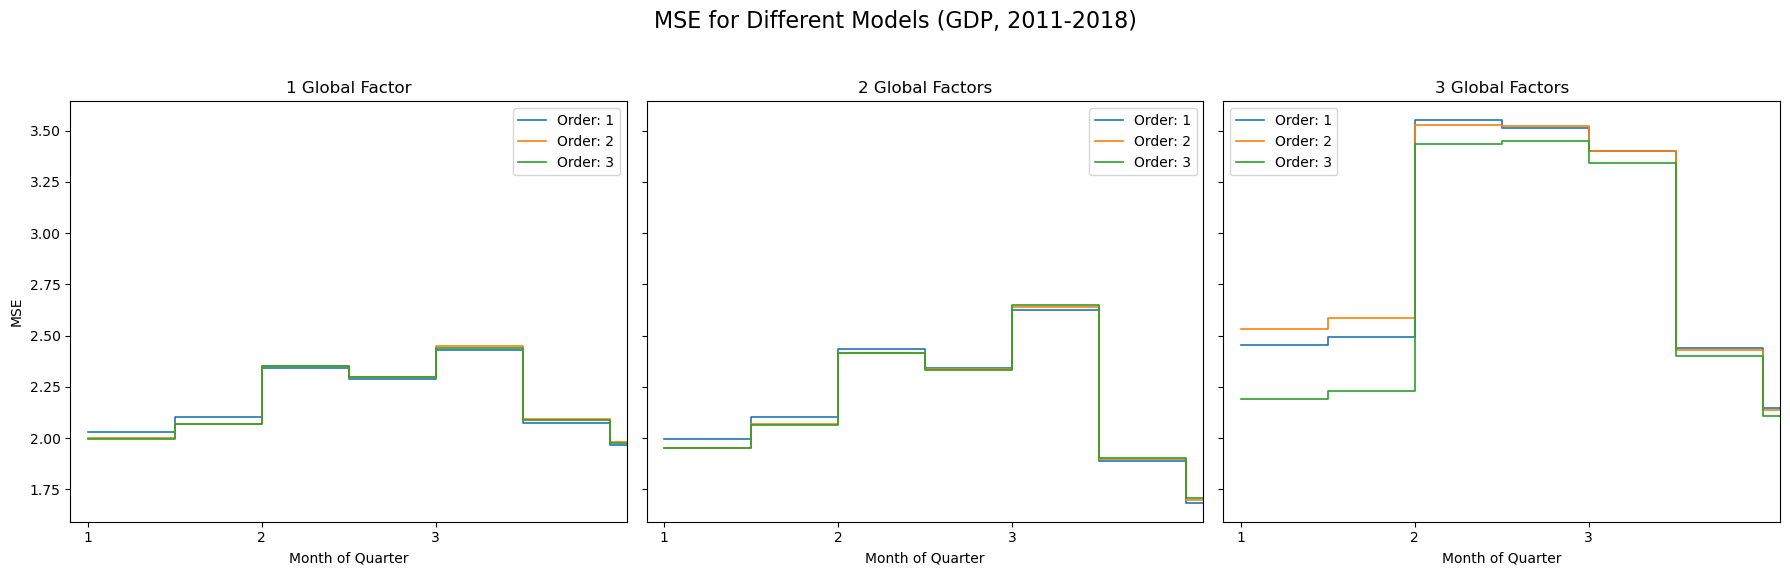

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


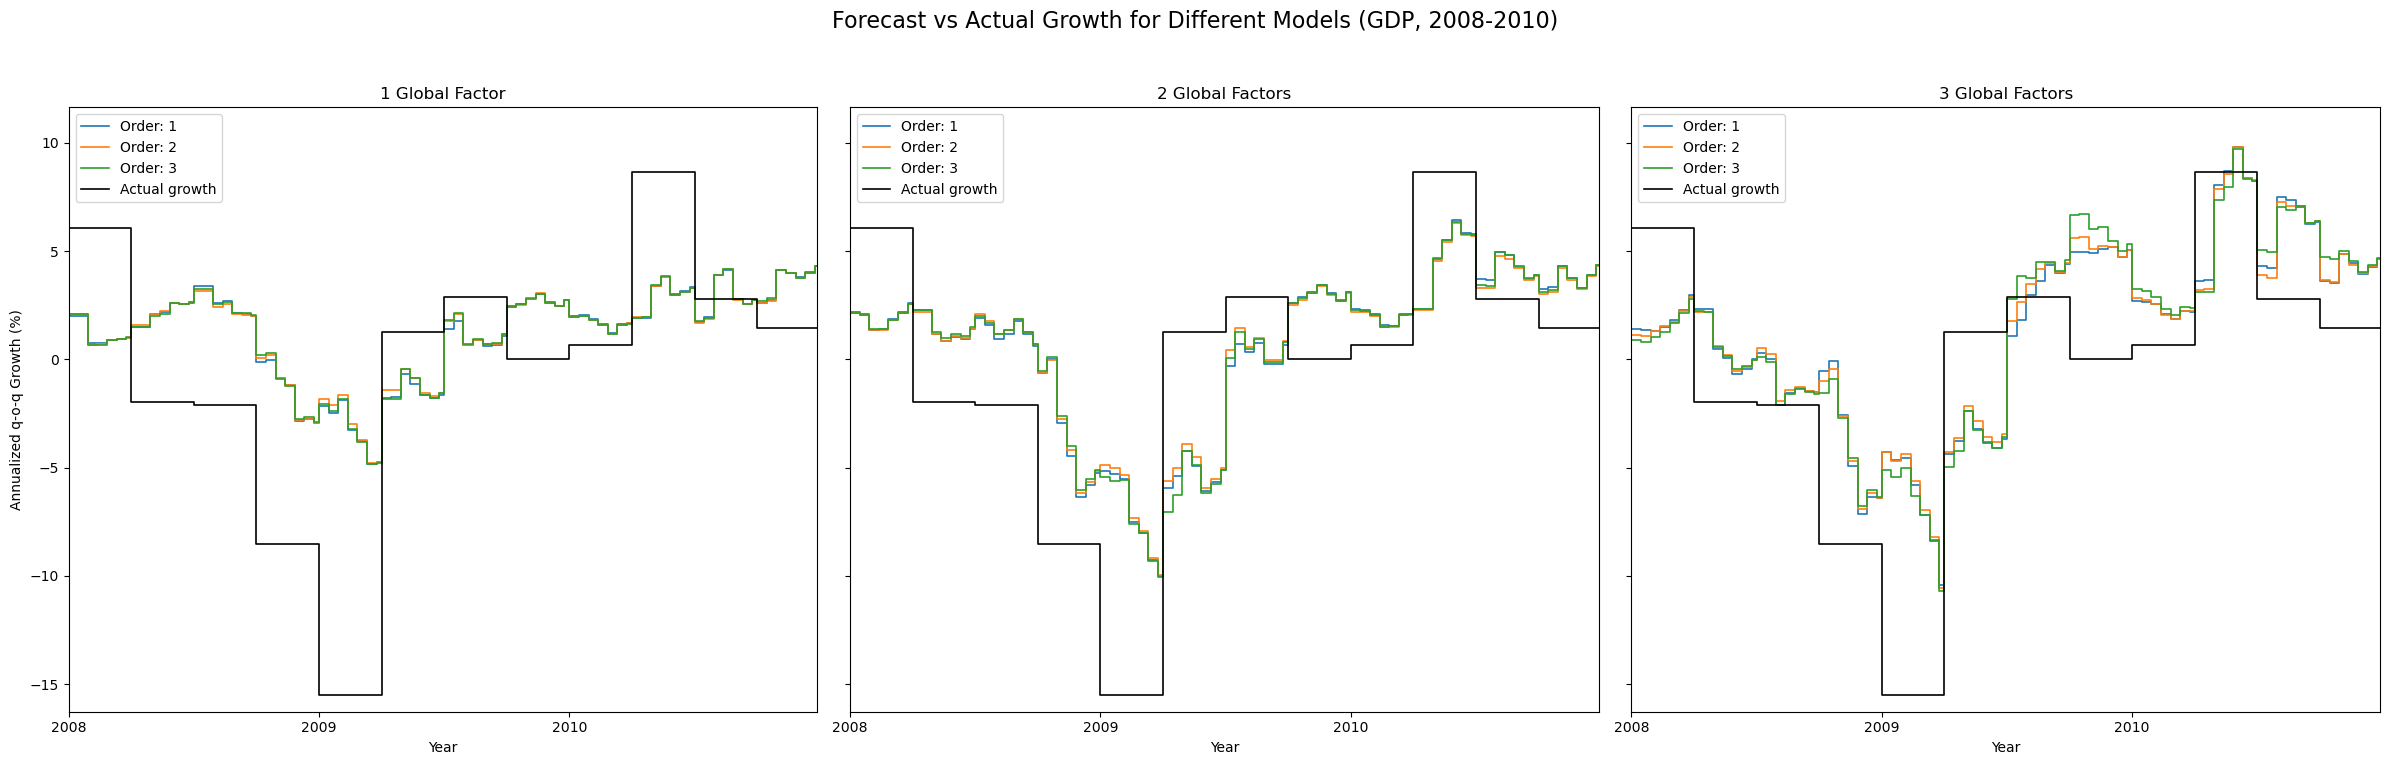

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


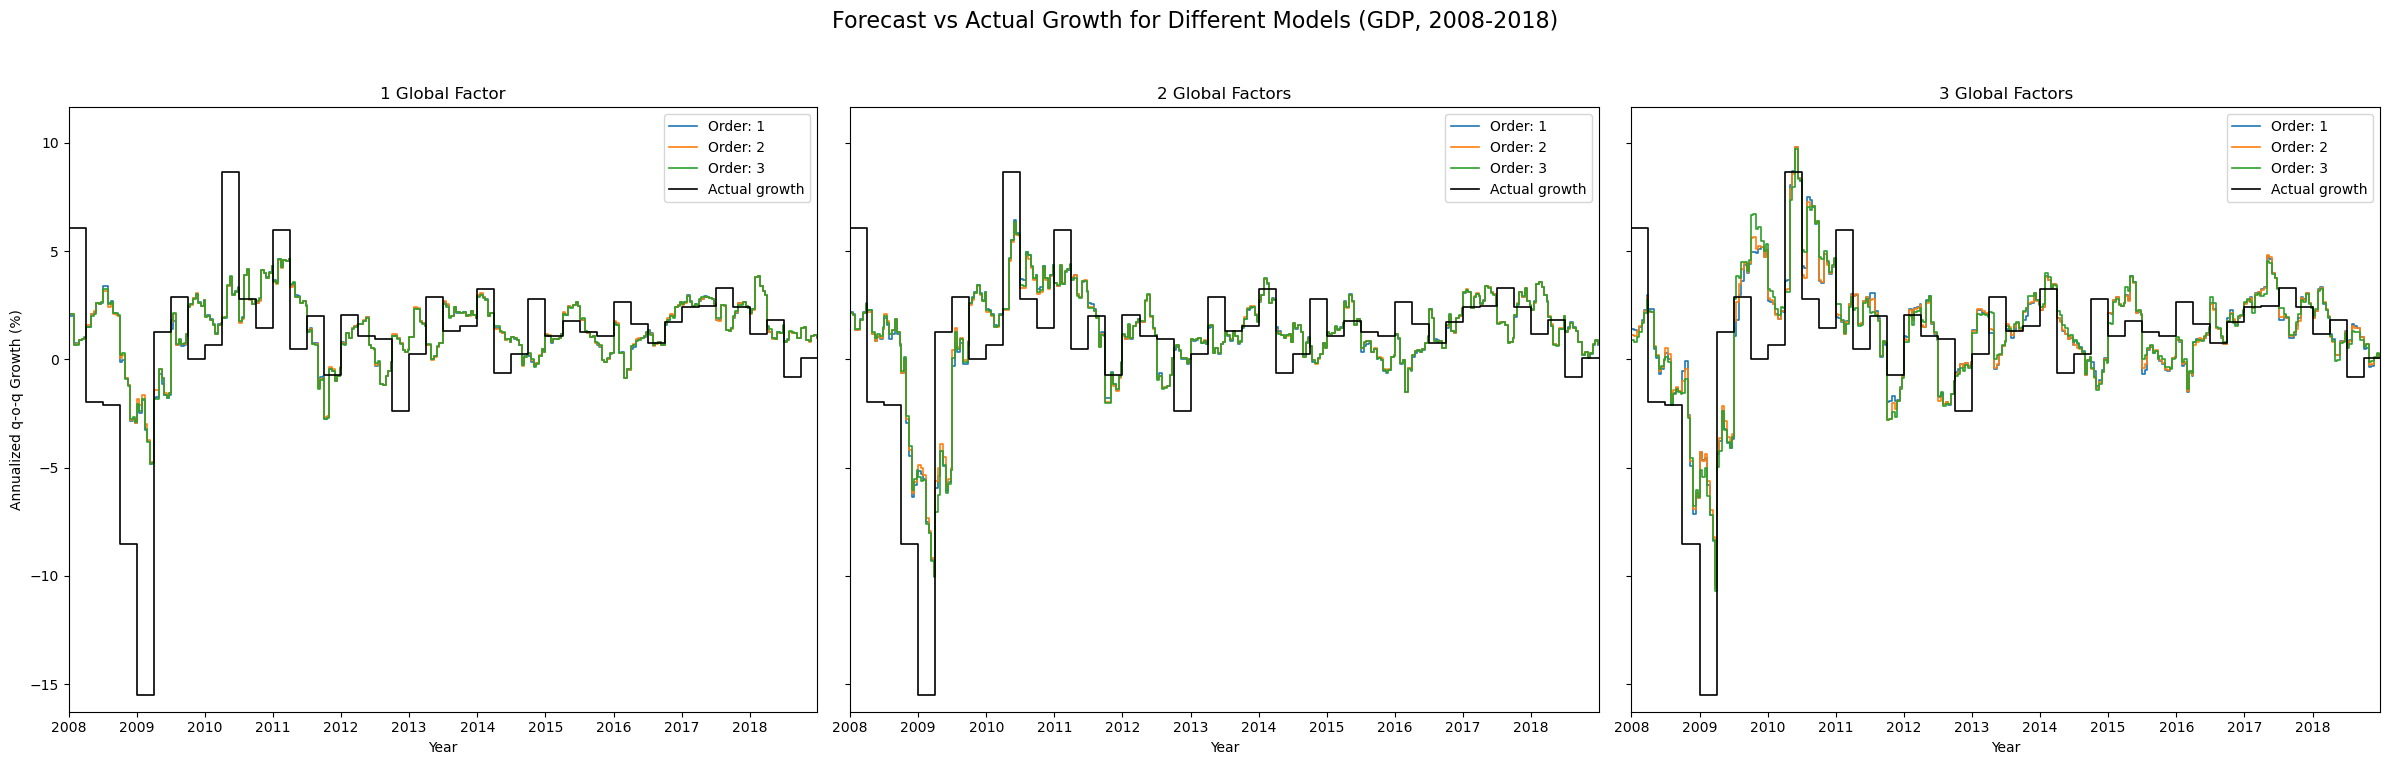

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


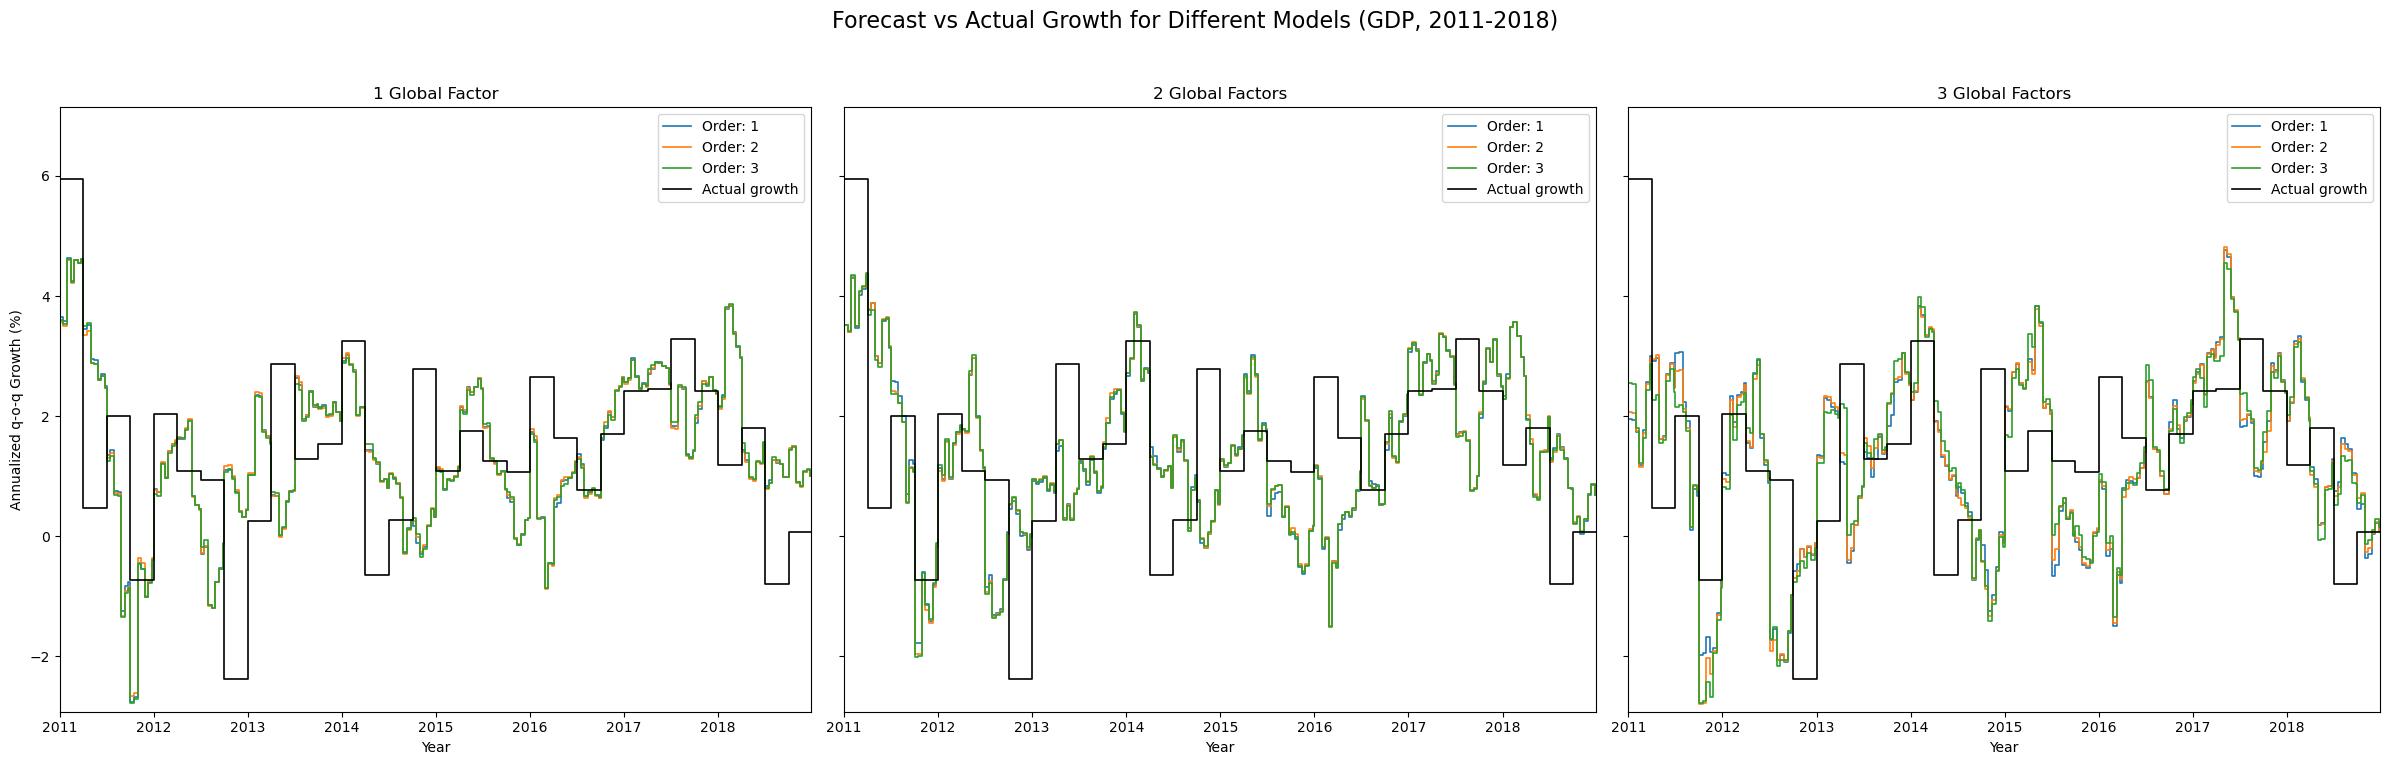

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()